In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Part 1 Exploratory Data Analysis

Loading the Data

In [2]:
logins_df = pd.read_json('logins.json')
logins_df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


Changing login_time column into proper format:

In [3]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
logins_df['count'] = 1
#setting login time as index 
logins_df.index = logins_df['login_time']

#dropping 
logins_df.drop('login_time',axis=1,inplace=True)
logins_df.head()

,count
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


Plotting Count of login_tim by 15 minutes:

<Axes: xlabel='login_time'>

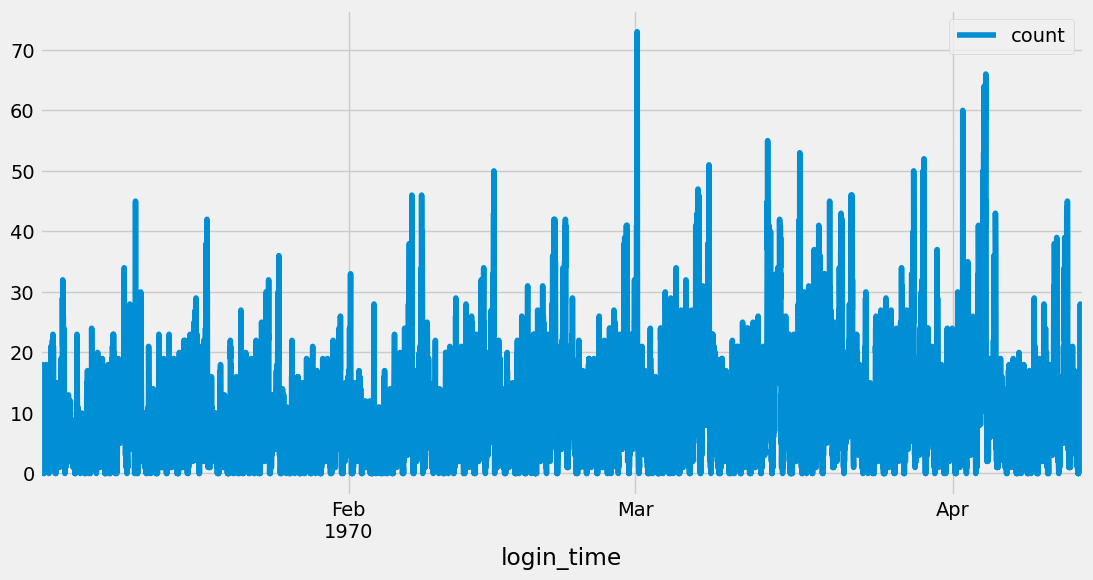

In [7]:
count_df = logins_df.resample('15min').sum()
count_df.plot(kind='line',figsize=(12,6))

There seems to be a clear pattern when login_time is separated by 15 minutes. There is a surge after some amount of days, goes down significantly, goes back up slighlty, down again, and then a big surge again. From the graph above there we can take away some relevant information. 

Simple statistical information:

In [13]:
count_df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


We now know that there is a standard deviation of 8.32 and a mean of 9.5. The minimum value count is 0 and  there are times where the maximum count is 73. Lets take a look at some graphs similar to the one above, but only take a random ranged subset of observations. 

In [22]:
count_df.shape

(9788, 1)

We will subset rows by one week:

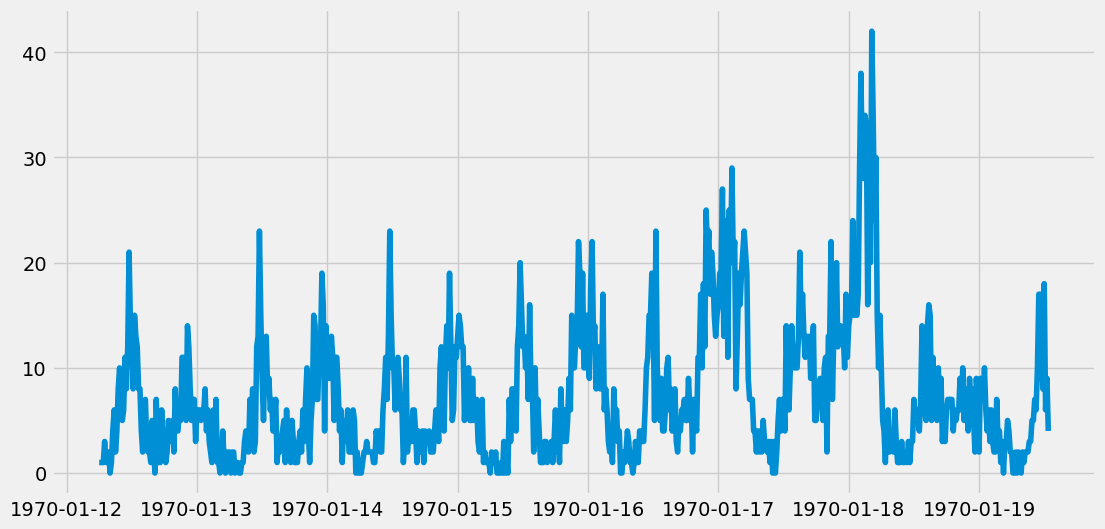

In [24]:
plt.figure(figsize=(12,6))
plt.plot(count_df[1000:1700])

Subsetting by two weeks:

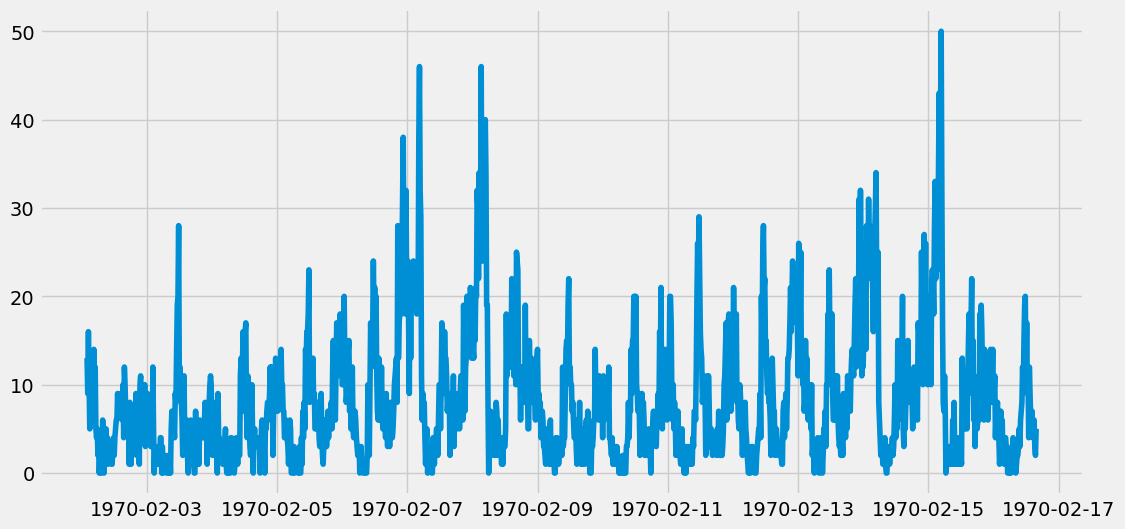

In [29]:
plt.figure(figsize=(12,6))
plt.plot(count_df[3000:4400])

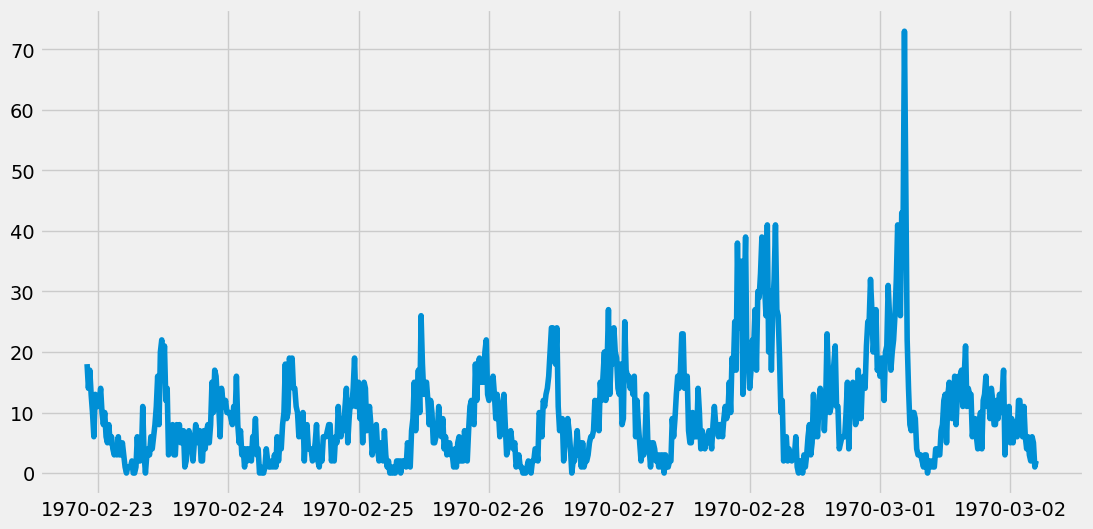

In [27]:
plt.figure(figsize=(12,6))
plt.plot(count_df[5000:5700])

Looking at these graphs, we can see that the peaks on a weekly basis occurs every 12 hours. There is a slight surge in the middle between the two points of where the new day starts.

In [20]:
top_10_peaks = count_df.groupby(count_df.index.date).max().nlargest(10, columns='count')

print(top_10_peaks)

            count
1970-03-01     73
1970-04-04     66
1970-04-01     60
1970-03-13     55
1970-03-17     53
1970-03-29     52
1970-03-08     51
1970-02-15     50
1970-03-28     50
1970-04-03     50


In [21]:
low_10_peaks = count_df.groupby(count_df.index.date).max().nsmallest(10, columns='count')
print(low_10_peaks)

            count
1970-01-01     16
1970-02-02     17
1970-02-04     17
1970-01-19     18
1970-01-27     19
1970-01-29     19
1970-02-24     19
1970-03-09     19
1970-04-06     19
1970-01-07     20


Max peak is count of 73, occuring on a Sunday. The more significant surges/peaks occurs more on the weekends.
All in all, Based on some quick data analysis, I observed that there is a recurring pattern in login activity, typically with peaks occurring every 12 hours. These peaks tend to start building up slowly in the morning and reach their highest point in the afternoon. Additionally, I noticed a gradual increase in usage throughout the week, with activity reaching its peak during the weekend.

# Part 2 Experiment and Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.


The key measure of success for this experiment would be the increase in the number of driver partners crossing the toll bridge between the two cities. This metric directly reflects the behavior change the experiment aims to achieve – encouraging driver partners to serve both cities by reimbursing toll costs. By tracking the number of crossings, we can assess whether the intervention effectively incentivizes drivers to operate in both Gotham and Metropolis.

Practical Experiment Design:

a) Implementation:

Initially, collect baseline data on the number of driver crossings across the toll bridge for a defined period before implementing the reimbursement policy.
Once the policy has been stated, continue monitoring the number of crossings over a specified period.
Analyze the data to compare the crossings before and after the policy change.

b) Statistical Tests:

Conduct a hypothesis test, such as a two-sample t-test, to determine if there is a significant difference in the mean number of crossings before and after the policy change.
Set the null hypothesis as "there is no significant difference in the mean number of crossings before and after the policy change," and the alternative hypothesis as "there is a significant difference."
Calculate the p-value to assess the likelihood of observing the data if the null hypothesis were true.
If the p-value is below a predetermined significance level (e.g., 0.05), reject the null hypothesis and conclude that the policy change has had a significant effect.

c) Interpretation and Recommendations:

If the statistical test shows a significant increase in the mean number of crossings after implementing the reimbursement policy, it indicates that the intervention has been successful in encouraging driver partners to serve both cities.
We ca then provide recommendations to continue or expand the reimbursement policy based on the observed impact.
Some warnings may include other factors influencing driver behavior, such as changes in demand, weather conditions, or competing incentives. It's essential to consider these factors when interpreting the results and making recommendations. Additionally, ongoing monitoring and further analysis may be necessary to assess the long- effectiveness and sustainability of the intervention.


# Part 3: Predictive Modeling

Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [32]:
ultimate = pd.read_json('ultimate_data_challenge.json')
ultimate.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [34]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [41]:
ultimate.shape

(50000, 12)

In [35]:
ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


We may need to clean the dataset first before modeling to make the predictions:

In [38]:
ultimate.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [37]:
ultimate[['last_trip_date', 'signup_date']].describe()

,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29,2014-01-18
freq,2036,2948


In [39]:
ultimate[['avg_rating_of_driver']].describe()

,avg_rating_of_driver
count,41878.000000
mean,4.601559
std,0.617338
min,1.000000
25%,4.300000
50%,4.900000
75%,5.000000
max,5.000000


In [40]:
ultimate[['avg_rating_by_driver']].describe()

,avg_rating_by_driver
count,49799.000000
mean,4.778158
std,0.446652
min,1.000000
25%,4.700000
50%,5.000000
75%,5.000000
max,5.000000


The missing values will be filled with mean and median values:

In [43]:
fill_missing = (4.778158 + 5) / 2
arod = 4.9

ultimate['avg_rating_of_driver'] = ultimate['avg_rating_of_driver'].fillna(value=arod)
ultimate['avg_rating_by_driver'] = ultimate['avg_rating_by_driver'].fillna(value=fill_missing)

In [44]:
ultimate.isnull().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [48]:
ultimate['avg_rating_of_driver'].describe()

count    49604.00000
mean         4.64977
std          0.57582
min          1.00000
25%          4.50000
50%          4.90000
75%          5.00000
max          5.00000
Name: avg_rating_of_driver, dtype: float64

In [49]:
ultimate['avg_rating_by_driver'].describe()

count    49604.000000
mean         4.778305
std          0.446275
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

Lets take care of the 'phone' variable from the ultimate dataframe:

In [45]:
ultimate = ultimate.drop(ultimate[ultimate['phone'].isna()==True].index,axis=0)

In [46]:
ultimate.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

The dataset is now clean.

Feature Engineering:

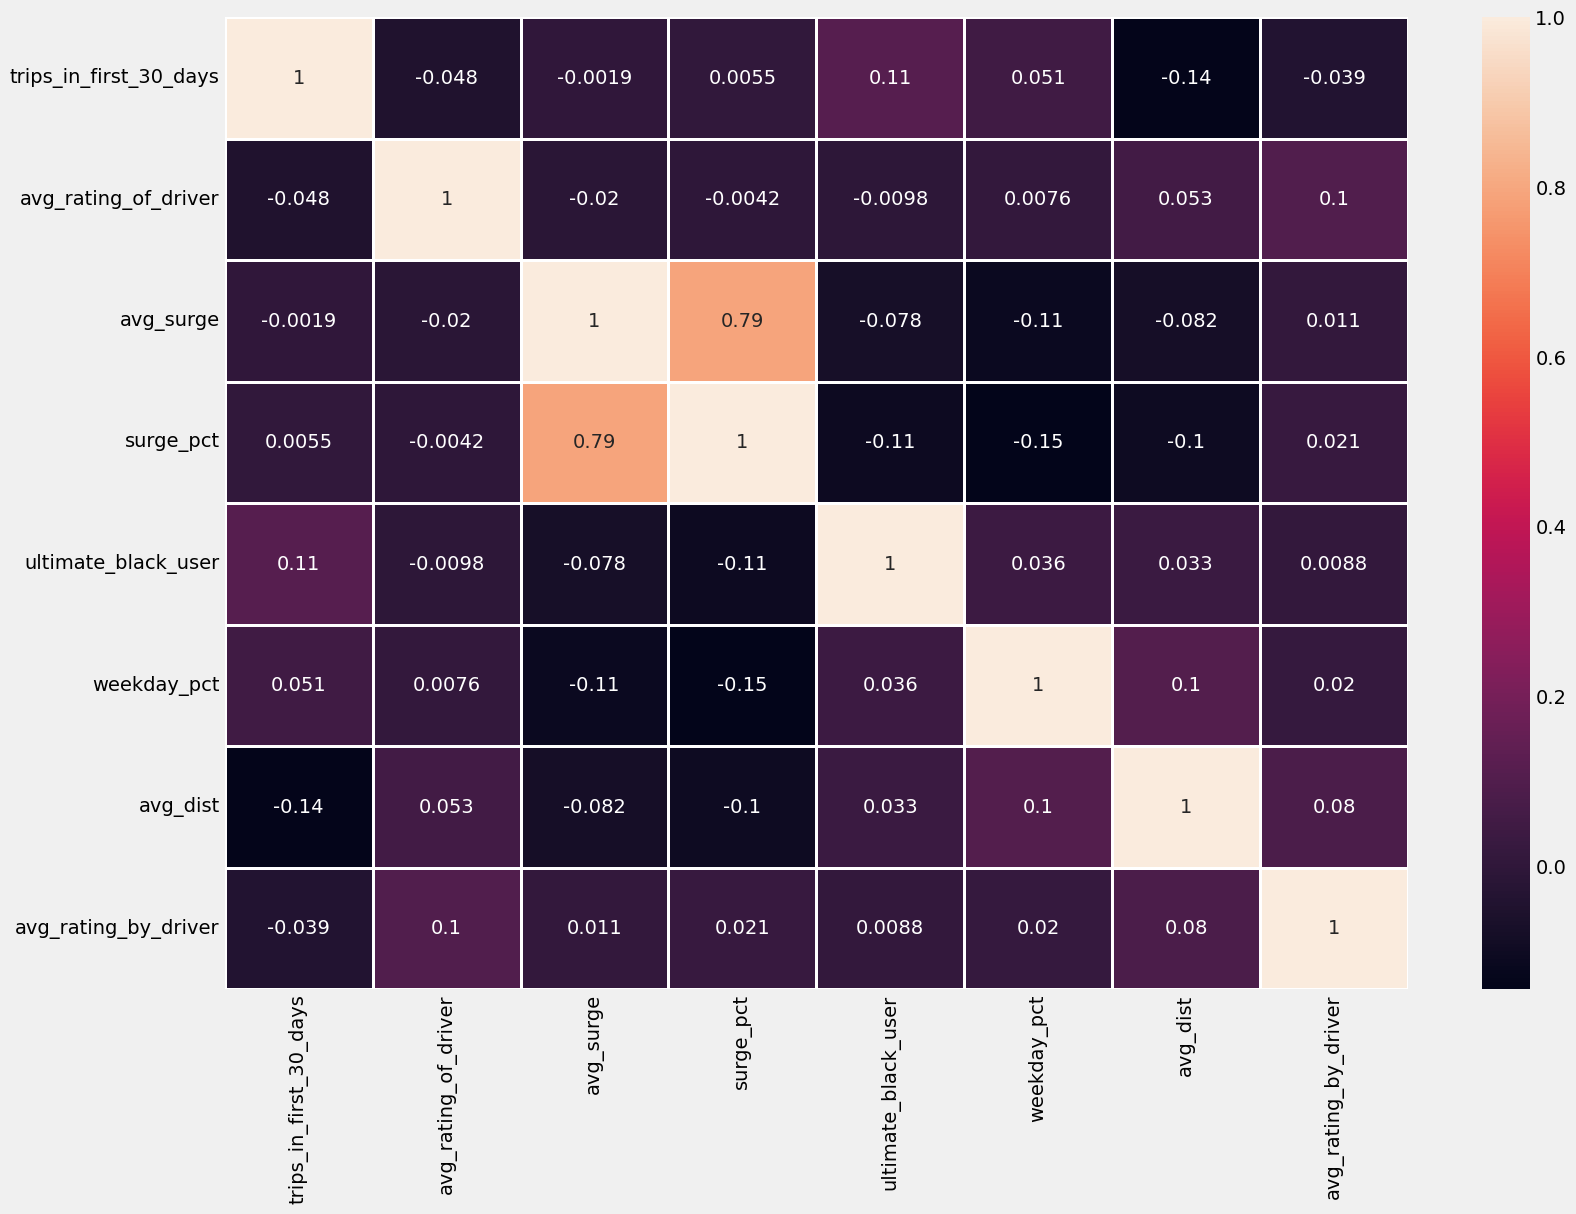

In [50]:
plt.figure(figsize=(17,12))

corr = ultimate.corr()
sns.heatmap(corr, annot=True, linewidths=1)

plt.show()

We will create a new variable to indicate the current date to find out active users. Here is the code:

In [51]:
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])

current_date = ultimate['last_trip_date'].max()

ultimate['active'] = (current_date - ultimate['last_trip_date']).dt.days <= 30

# Converting boolean values to integers (0 for inactive, 1 for active)
ultimate['active'] = ultimate['active'].astype(int)

ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Percentage of active users:

In [52]:
percentage_active = ultimate['active'].mean() * 100

print("Percentage of active users:", percentage_active)

Percentage of active users: 37.640109668575114


37.63% of users are active while the other 62% are not.

Creating dummy variables:

In [53]:
#creating dummy variables for categorical features
ultimate_features = pd.get_dummies(ultimate,columns=['city','phone','ultimate_black_user'])
ultimate_features.head()
#setting target variable and dropping columns that are not needed
target = ultimate_features['active']
ultimate_features = ultimate_features.drop(['last_trip_date','signup_date','active'],axis=1)

# Exploratory Data Analysis:

<Axes: xlabel='active', ylabel='avg_dist'>

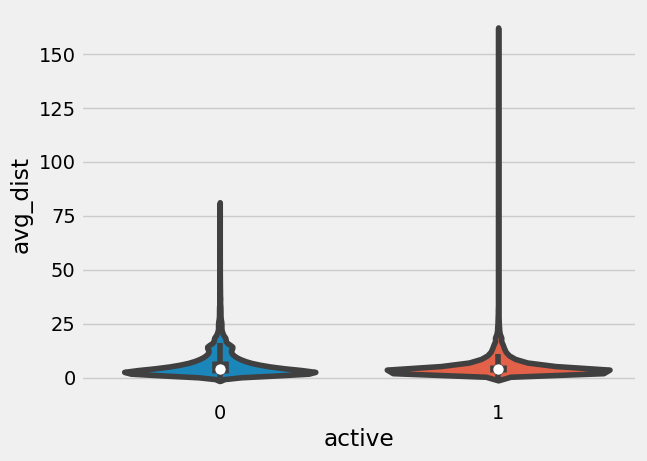

In [54]:
sns.violinplot(data=ultimate,x='active',y='avg_dist')

<Axes: xlabel='avg_dist', ylabel='active'>

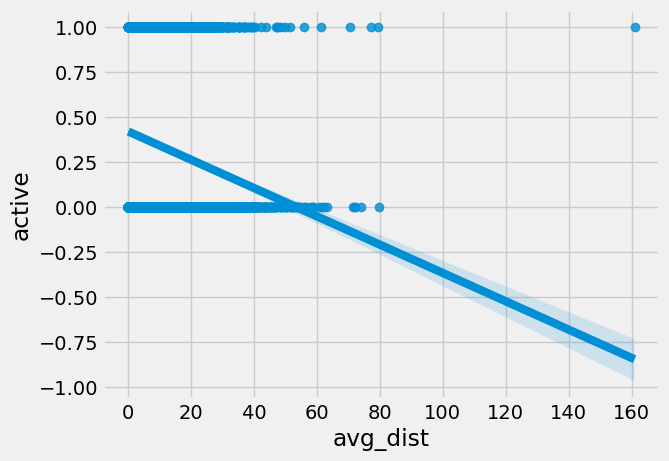

In [55]:
sns.regplot(y = ultimate['active'], x = ultimate['avg_dist'], fit_reg = True)

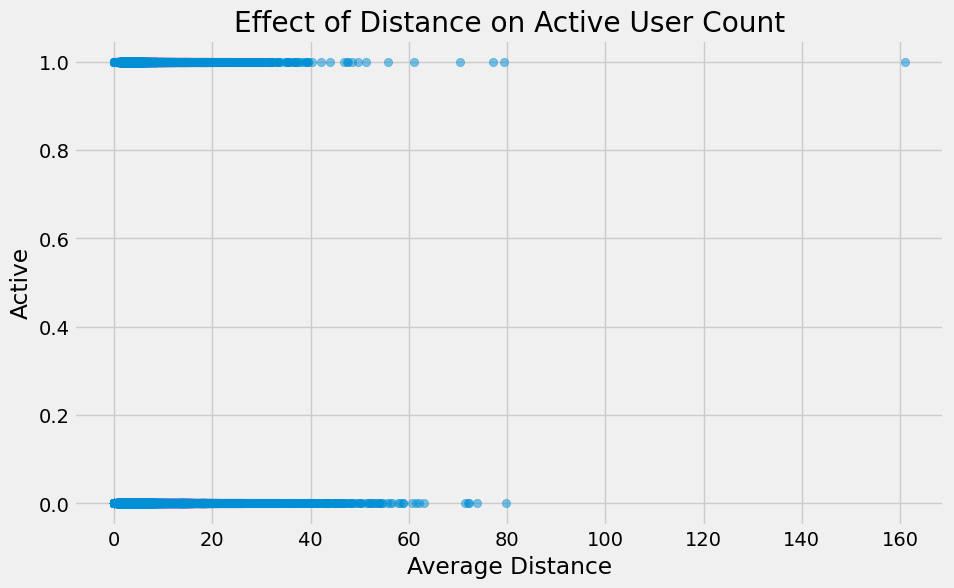

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(ultimate['avg_dist'], ultimate['active'], alpha=0.5)
plt.title('Effect of Distance on Active User Count')
plt.xlabel('Average Distance')
plt.ylabel('Active')
plt.grid(True)
plt.show()

We can see that as distance increases, it is more likely that the app can not retain its active users.

Lets see how active users compare with the average rating by driver:

In [58]:
pd.pivot_table(ultimate,index='active',aggfunc={'avg_rating_by_driver':['median','std']})

avg_rating_by_driver          
                     median       std
active                               
0                       5.0  0.503901
1                       4.8  0.328753

Active users have lower ratings than inactive users. Intersting. We can maybe assume that the reason active users have lower ratings because they have more short distance trips, giving them a higher chance of drivers giving lower ratings.

In [60]:
pd.pivot_table(ultimate,index='active',aggfunc={'trips_in_first_30_days':['mean','std']})

trips_in_first_30_days          
                         mean       std
active                                 
0                    1.657033  2.655767
1                    3.304804  4.985057

On average, active users take 3.3 trips in the first 30 days in comparison to inactive users who take 1.65 trips in first 30 days.

# Modeling:

Lets remind ourselves what percentage of active users(1) we are dealing with in comparison to inactive users(0):

In [62]:
ultimate['active'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

0    62.36%
1    37.64%
Name: active, dtype: object

Before starting, we have to know that feature scaling is a crucial preprocessing step in many machine learning algorithms. It ensures that all features have the same scale, which can help improve the performance and convergence of many machine learning algorithms. We will do that below:

In [64]:
scaled = QuantileTransformer()
scaled_features = scaled.fit_transform(ultimate_features)

In [67]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  object        
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  active                  49604 non-null  int64 

Because the dataset contains a relatively small number of features, there's no need to decrease its dimensionality through techniques like Principal Component Analysis (PCA). Instead, we'll utilize the Random Forest Classifier. This classifier is chosen because of its strong predictive capabilities and its ability to provide us with valuable information regarding the importance of different features in making predictions.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=1000, random_state=42).fit(X_train, y_train)

# Evaluating model and print accuracy score
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7500251990726742


In [70]:
significant_ultimate = pd.DataFrame(zip(list(ultimate_features.columns),rf.feature_importances_),index=range(ultimate_features.columns.shape[0]),columns=['feature','importance'])
significant_ultimate.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.300798
4,weekday_pct,0.133561
6,avg_rating_by_driver,0.112424
0,trips_in_first_30_days,0.081406
1,avg_rating_of_driver,0.080810
3,surge_pct,0.077834
2,avg_surge,0.066829
8,city_King's Landing,0.046797
11,phone_iPhone,0.019890
10,phone_Android,0.019483


# Remarks after moedeling:

Based on the feature importances provided by the random forest model, Ultimate can focus on certain factors that are highly predictive of rider retention. The average distance of trips taken by riders appears to be the most important feature, suggesting that encouraging longer trips or providing incentives for such trips could potentially improve long-term rider retention. Additionally, factors like the percentage of trips taken during weekdays and the ratings given by both riders and drivers also play significant roles, indicating that improving weekday availability and ensuring high-quality experiences for both parties could contribute to enhanced rider retention over time.